**Payoff Pricing**

Once we understand the payoff and where the risks lie, the pricing is typically nothing more than numerical simulations such as Monte Carlo methods.

The price of an exotic option is generally based on simulating a large set of paths and subsequently dividing the sum of the payoffs by the total number of paths generated.

**1. Initialisation**

In [1]:
#Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
def GeoPaths(M, I, S0, T, r, sigma):
    
    """

    Parameters
    ----------
    M : integer
        number of intervals for discretisation.
    I : integer
        number of paths to be simulated.
    S0 : float
        initial value of the underlying.
    T : float
        maturity in year.
    r : float
        the constant, riskless rate.
    sigma : float
        the constant instantaneous volatility.

    Returns
    -------
    Geometric Paths.
    
    """
    
    dt   = T / M                                      #discretisation 
    S    = np.zeros((M + 1,I))                        #we create an initial array with shape(M+1,I)
    S[0] = S0                                         #the inital value of the underlying
    e    = np.random.standard_normal(S.shape)         #random numbers, drawn in a signle vectorised step
    
    for t in range(1,M+1):                            #vectorisation
            S[t] = S[t - 1] * np.exp((r - sigma ** 2 /2) * dt + sigma * np.sqrt(dt) * e[t])
    
    return S

In [16]:
#Initialise the parameters

I  = 100000
M  = 252   
S0 = 100       
T  = 1       
r  = 0.05      
sigma = 0.2    

%time paths = GeoPaths(M, I, S0, T, r, sigma)

CPU times: user 904 ms, sys: 121 ms, total: 1.03 s
Wall time: 1.06 s


In [17]:
#We can now check the theoretically expected end-of-period value of our initial stock price
round(paths[-1].mean(),2)

105.09

In [18]:
#Future Value
round(S0 * np.exp(r * T),2)

105.13

Text(0.5, 1.0, 'Geometric Brownian Motion')

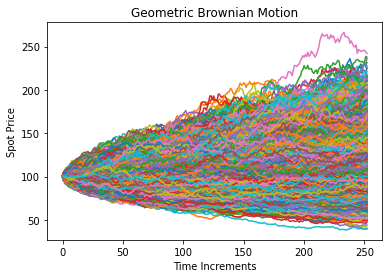

In [19]:
#Plot the results
plt.plot(paths)
plt.xlabel("Time Increments")
plt.ylabel("Spot Price")
plt.title("Geometric Brownian Motion")

**2. European Vanilla Call**

In [9]:
St = paths[-1]        #european observation, we take the last increment -> at maturity
K = S0 * 1            #strike

#The fair final coupon of the payoff with the discount factor
hT = np.maximum(St - K, 0)
fairCoupon = np.mean(hT) * np.exp(-r * T)       
print("Fair price:",round(fairCoupon/K,3)*100,'%')

Fair price: 10.5 %


**3.a. European Digital**

In [28]:
def EuropeanDigit(S0, K, T, r, sigma, barrier, coupon):
    
    """
    Parameters
    ----------
    S0 : float
        initial value of the underlying.
    K : float
        strike level.
    T : float
        maturity in year.
    r : float
        the constant, riskless rate.
    sigma : float
        the constant instantaneous volatility.
    barrier : float
        the performance barrier.
    coupon : float
        the performance if the barrier is touched.

    Returns
    -------
    European Digital Option Fair Price.
    
    """
    
    pathsDigit = GeoPaths(M, I, S0, T, r, sigma)
    maturityPerf = (pathsDigit[-1]/K)-1
    x = np.where(maturityPerf>=barrier,coupon,0)
    Digit = np.mean(np.maximum(x,0)) * np.exp(-r*T)

    return Digit

In [23]:
S0 = 100           
K = S0 * 1         
T  = 1             
r  = 0.05         
sigma = 0.2        
barrier = 0.00     
coupon = S0 * 0.02

EuDigit = EuropeanDigit(S0, K, T, r, sigma,barrier,coupon)
print("Digital Fair Coupon:",round(EuDigit,2),'%')

Digital Fair Coupon: 1.07 %


**3.b. Call Spread Replication**

In [32]:
def CallSpread(S0, K1, K2, T, r, sigma, gearing):
    
    """
    Parameters
    ----------
    S0 : float
        initial value of the underlying.
    K1 : float
        first strike level (long).
    K2 : float
        second strike level (short).
    T : float
        maturity in year.
    r : float
        the constant, riskless rate.
    sigma : float
        the constant instantaneous volatility.
    gearing : float
        participation.

    Returns
    -------
    Call Spread Fair Price.

    """
    
    pathsCS = GeoPaths(M, I, S0, T, r, sigma)
    maturityPerf = pathsCS[-1]
    hTCallSpread = gearing * (np.maximum(maturityPerf - K1, 0) - (np.maximum(maturityPerf - K2, 0)))
    CallSpread = np.mean(hTCallSpread) * np.exp(-r*T)

    return CallSpread    

In [33]:
S0 = 100        
K1 = 99.8
K2 = 100
T  = 1
r  = 0.05
sigma = 0.2
gearing = 10

CallSpread = CallSpread(S0, K1, K2, T, r, sigma, gearing)
print('Call Spread:',round(CallSpread,2),'%')

Call Spread: 1.07 %


**4. Call Up And Out - European Observation (Vectorised Version)**

In [34]:
def CallUpAndOutEuVec(S0,K, T, r, sigma, barrier, rebate):
    
    """

    Parameters
    ----------
    S0 : float
        initial value of the underlying.
    K : float
        strike level.
    T : float
        maturity in year.
    r : float
        the constant, riskless rate.
    sigma : float
        the constant instantaneous volatility.
    barrier : float
        the performance barrier.
    rebate : float
        the performance if the barrier is touched.

    Returns
    -------
    European Observation Call Up and Out Fair Price.

    """
       
    pathsExo = GeoPaths(M, I, S0, T, r, sigma)
    maturityPerf = (pathsExo[-1]/K)-1
    maturityPerf[maturityPerf>=barrier] = rebate
    CallUpAndOut = np.mean(np.maximum(maturityPerf,0)) * np.exp(-r*T)
    
    return CallUpAndOut

In [35]:
S0 = 100       #initial value of the underlying
K = S0 * 1     #strike price
T  = 1         #maturity in year
r  = 0.05      #the constant, riskless shote rate
sigma = 0.2    #the constant instantaneous volatility
barrier = 0.3  #the performance barrier
rebate = 0.01  #the performance if the barrier is touched

CallUpAndOutVec = CallUpAndOutEuVec(S0, K, T, r, sigma,barrier,rebate)
print("Call Up & Out:",round(CallUpAndOutVec*100,2),'%')

Call Up & Out: 5.4 %
